In [23]:
import torch
import random
import numpy as np

# set random seed
seed = 66
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)          
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from torchvision.datasets import mnist # import dataset

from torch import nn
from torch.autograd import Variable

In [24]:
# Convert the data
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5
    x = x.reshape((-1,))
    x = torch.from_numpy(x)
    return x

train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True)
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

In [25]:
# print the shape of data
a, a_label = train_set[0]
print(a.shape)
print(a_label)

torch.Size([784])
5


In [26]:
# Set the data size of a batch
from torch.utils.data import DataLoader
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)
a, a_label = next(iter(train_data))
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


In [27]:
# Four-layer network
net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),  # Activation function: ReLU 
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)
net

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)

In [28]:
# Define Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), 1e-1) # learning rate = 0.1

In [29]:
# Training with GPU
import torch
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
device

device(type='cuda')

epoch: 0, Train Loss: 0.508645, Train Acc: 0.834155, Eval Loss: 0.222736, Eval Acc: 0.926622
epoch: 1, Train Loss: 0.170361, Train Acc: 0.947328, Eval Loss: 0.222894, Eval Acc: 0.926622
epoch: 2, Train Loss: 0.118125, Train Acc: 0.962986, Eval Loss: 0.456636, Eval Acc: 0.873418
epoch: 3, Train Loss: 0.092508, Train Acc: 0.971648, Eval Loss: 0.099989, Eval Acc: 0.967563
epoch: 4, Train Loss: 0.076358, Train Acc: 0.975580, Eval Loss: 0.089587, Eval Acc: 0.972211
epoch: 5, Train Loss: 0.062116, Train Acc: 0.980277, Eval Loss: 0.121316, Eval Acc: 0.961926
epoch: 6, Train Loss: 0.053821, Train Acc: 0.982609, Eval Loss: 0.111393, Eval Acc: 0.966673
epoch: 7, Train Loss: 0.043748, Train Acc: 0.985774, Eval Loss: 0.102526, Eval Acc: 0.967662
epoch: 8, Train Loss: 0.040818, Train Acc: 0.986774, Eval Loss: 0.074537, Eval Acc: 0.980024
epoch: 9, Train Loss: 0.035046, Train Acc: 0.988889, Eval Loss: 0.066756, Eval Acc: 0.978540
epoch: 10, Train Loss: 0.029687, Train Acc: 0.990055, Eval Loss: 0.070

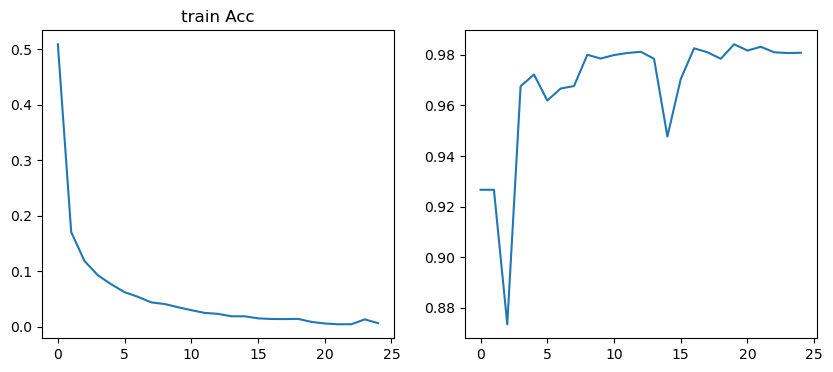

In [30]:
import matplotlib.pyplot as plt
# Ensure inline plotting in the notebook
%matplotlib inline
# Train
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(25):
    train_loss = 0
    train_acc = 0
    net.train() 
    for im, label in train_data:
        # GPU
        im = im.to(device)
        label = label.to(device)
        im = Variable(im)
        label = Variable(label)
        # Train the net
        out = net(im)
        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate the accuracy
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    
    # test
    eval_loss = 0
    eval_acc = 0
    net.eval()
    with torch.no_grad():
        for im, label in test_data:
            # GPU
            im = im.to(device)
            label = label.to(device)
            im = Variable(im)
            label = Variable(label)
            # Test the net
            out = net(im)
            loss = criterion(out, label)
            eval_loss += loss.item()
            _, pred = out.max(1)
            num_correct = (pred == label).sum().item()
            acc = num_correct / im.shape[0]
            eval_acc += acc

    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))

    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                  eval_loss / len(test_data), eval_acc / len(test_data)))
    # print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}'
    #       .format(e, train_loss / len(train_data), train_acc / len(train_data)))
print("Accuracy{:.2f}%".format(100*(eval_acc / len(test_data))))

# plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.title('train Acc')
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(eval_acces)), eval_acces)